In [9]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
mnist = fetch_mldata("MNIST original")
pca = PCA(n_components=100)
MX = pca.fit_transform(mnist.data / 255.0)
My = mnist.target
print('Explained total variation: ,', format(sum(pca.explained_variance_ratio_)))

Explained total variation: , 0.914627306596236


In [10]:
print(MX.shape)

(70000, 100)


In [11]:
rndperm = np.random.permutation(MX.shape[0])

In [12]:
def partitionData(X,y, num_points=10000, num_pivots=500):
    pivots = X[:num_pivots]
    sample_X = X[num_pivots:num_points+num_pivots]
    sample_y = y[num_pivots:num_points+num_pivots]
    return sample_X, sample_y, pivots

In [97]:
num_points = 5000
num_pivots = 500
sample_MX, sample_My, Mpivots = partitionData(MX[rndperm], My[rndperm],
                                              num_points=num_points,
                                              num_pivots=num_pivots)

In [98]:
def distanceMatrix(X,Y):
    A, _ = np.shape(X)
    B, _ = np.shape(Y)
    X2 = np.sum(X**2, axis=1).reshape(-1,1)
    Y2 = np.sum(Y**2, axis=1).reshape(-1,1)
    XY = X.dot(Y.T)
    dm = X2 - 2*XY + Y2.T
    return dm

In [99]:
M_dm = distanceMatrix(sample_MX, Mpivots)
print(M_dm.shape)

(5000, 500)


In [100]:
def kNN(dm, k=5):
    dm_arr = np.asarray(dm)
    indices = np.argsort(dm_arr, axis=1)
    sorted_dm = np.sort(dm_arr, axis=1)
    return sorted_dm[:,:k], indices[:,:k]

In [101]:
M_knn_dist, M_knn_ind = kNN(M_dm, k=10)
print(M_knn_dist.shape)
print(M_knn_dist)
print(M_knn_ind.shape)
print(M_knn_ind)

(5000, 10)
[[ 30.05835716  35.18816264  35.63482452 ...,  39.72435833  39.93352419
   40.02477068]
 [ 30.91498861  36.78314687  38.07429413 ...,  42.67633114  43.25259671
   44.14153188]
 [ 38.19099057  39.25052051  41.82329137 ...,  51.56334216  52.84137932
   53.94396468]
 ..., 
 [ 27.72264364  31.3806251   32.05564966 ...,  39.07194847  39.67665972
   40.00265095]
 [ 24.76786804  41.58794502  47.42680235 ...,  56.40090738  56.76304094
   57.53408274]
 [ 27.09511031  31.17300277  33.6045905  ...,  55.40649361  56.93136456
   57.70047974]]
(5000, 10)
[[ 38 471  58 ..., 499 450 119]
 [469 213 190 ...,  16 457 492]
 [ 93 413  17 ..., 126 127 367]
 ..., 
 [ 16 161 324 ..., 396  47 412]
 [ 37 163 380 ..., 192  53 263]
 [418 364 419 ...,  50 341 467]]


In [102]:
# Co-Occurence Matrix
def coocMatrix(knn_ind, num_pivots=500):
    cooc_dm = np.zeros((num_pivots, num_pivots))
    N,k = knn_ind.shape
    for n in range(N):
        for i in range(k):
            for j in range(i+1,k):
                pi = knn_ind[n,i]
                pj = knn_ind[n,j]
                cooc_dm[pi,pj]+=1
                cooc_dm[pj,pi]+=1
    return cooc_dm+1

In [103]:
M_cooc_dm = coocMatrix(M_knn_ind, num_pivots)

In [104]:
M_pivots_dm = distanceMatrix(Mpivots, Mpivots)

In [105]:
import networkx as nx

colors = ["blue", "red", "green", "yellow", "brown", "pink", "orange", "gray", "cyan", "greenyellow"]

def genGraph(knn_dist, knn_ind, pivots_dm, cooc_dm, y):
    N,k = knn_dist.shape
    P,_ = pivots_dm.shape
    cooc_pivots_dm = np.divide(pivots_dm, cooc_dm)
    G=nx.Graph()
    weighted_edges = []
    for i in range(P):
        for j in range(i+1, P):
            weighted_edges.append((i,j,1/(cooc_pivots_dm[i,j]+1e-10)))
    
    for i in range(N):
        for j in range(k):
            weighted_edges.append((i+P,knn_ind[i,j],1/(knn_dist[i,j]+1e-10)))
        
    for i in range(N+P):
        G.add_node(i, {'color':colors[int(y[i])], 'cluster':int(y[i])})
    
    G.add_weighted_edges_from(weighted_edges)
    return G

In [106]:
MG = genGraph(M_knn_dist, M_knn_ind, M_pivots_dm, M_cooc_dm, My[rndperm])

In [107]:
print(MG.number_of_edges())

174750


In [108]:
Mpos = nx.spring_layout(MG, dim=2, iterations=100)

<IPython.core.display.Javascript object>


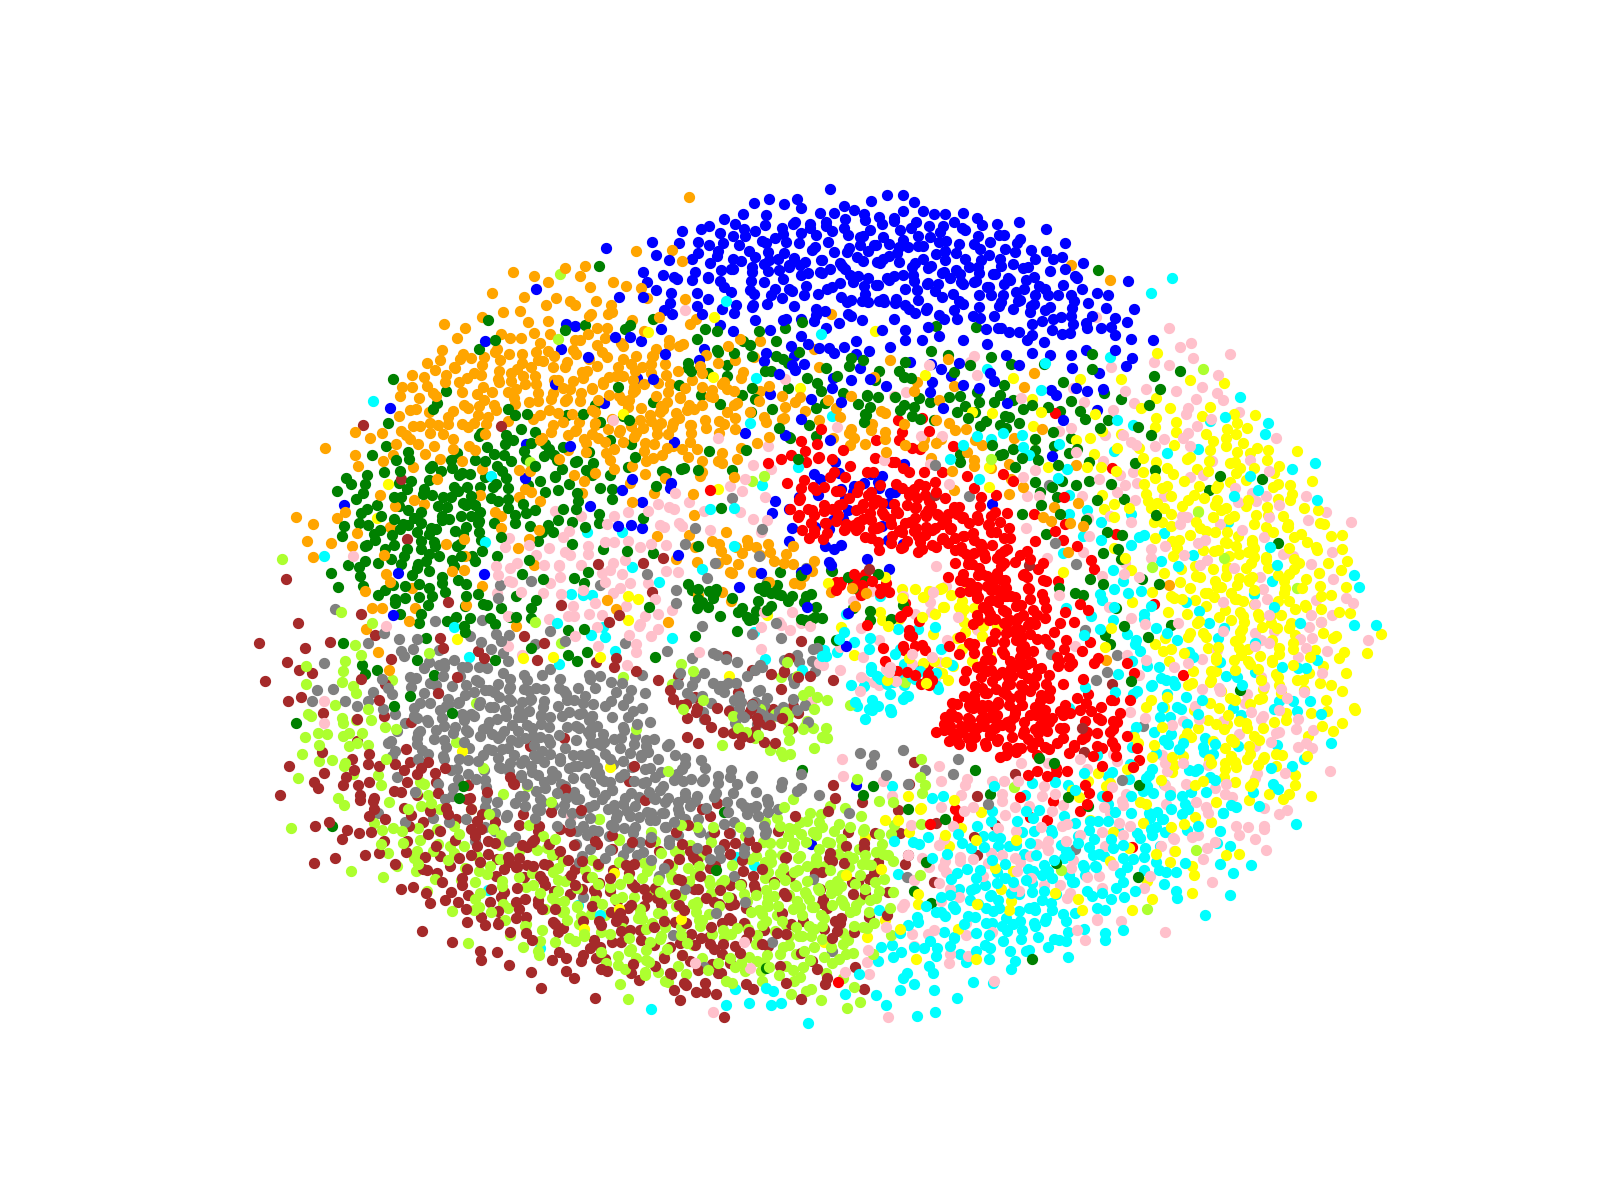

In [109]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.ion()
for n in range(num_pivots+num_points):
    nx.draw_networkx_nodes(MG,Mpos, with_labels=False, nodelist=[n], node_size=5,
                           node_color=colors[int(My[rndperm][n])])
plt.axis('off')
plt.show()